### Code for visualzing the results 

In [ ]:
import pandas as pd
import numpy as np
import sys
import torch

from sklearn.model_selection import train_test_split
from transformers import BertModel, BertTokenizer
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification, ModernBertModel

from transformers import get_scheduler

import torch.nn as nn
from torch.optim import AdamW

from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.metrics import f1_score
from tqdm.auto import tqdm
import torch.nn.functional as F

import seaborn as sns  
import matplotlib.pyplot as plt  

pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

In [593]:
label = 'emotive'
data = pd.read_csv(f'results/news_analysis/Label_{label}.csv')

In [594]:
# label = '3b'
# data_ = pd.read_csv(f'results/news_analysis/Label_{label}.csv')
# # data['victim'] = data_['Label_3b']

In [595]:
# def get_data(attr):
    
#     df = pd.read_csv(f'../../../../dataset/dataset_per_class/Label_{attr}.csv')
    
#     return df

# # attr = '4c'
# df = get_data(label)

# mapping = dict(zip(df['label'], df[f'lab_{label}']))
# # data[f'Label_{attr}'] = data[f'Lab_{label}'].replace(mapping)
# cols = ['score_' + l[1] for l in sorted(mapping.items(), key = lambda x: x[0])]

In [596]:
# data.to_csv('../ASP/github_code/data/GazaNews_war_and_peace.csv')

In [597]:
data['date'] = pd.to_datetime(data['publish_date'], format='%Y-%m-%d')
data['media'] = data.media_name.str.replace('aljazeera.com', 'alj').str.replace('foxnews.com', 'fox').str.replace('bbc.com', 'bbc').str.replace('bbc.co.uk', 'bbc')
data.media.value_counts()

alj    4321
fox    3114
bbc    2221
Name: media, dtype: int64

In [598]:
no_entity_mentioned_df = data[data[['pal_ent', 'hamas_ent', 'isr_ent', 'other_ent']].eq(False).all(axis = 1)]
pal_entity_mentioned_df = data[((data.pal_ent == True) & (data.hamas_ent == False) & (data.isr_ent == False) & (data.other_ent == False))]
hamas_entity_mentioned_df = data[((data.pal_ent == False) & (data.hamas_ent == True) & (data.isr_ent == False) & (data.other_ent == False))]
israel_entity_mentioned_df = data[((data.pal_ent == False) & (data.hamas_ent == False) & (data.isr_ent == True) & (data.other_ent == False))]
other_entity_mentioned_df = data[((data.pal_ent == False) & (data.hamas_ent == False) & (data.isr_ent == False) & (data.other_ent == True))]
other_entity_mentioned_df = pd.concat((no_entity_mentioned_df, other_entity_mentioned_df), axis = 0)

In [599]:
pal_entity_mentioned_df.shape, hamas_entity_mentioned_df.shape, israel_entity_mentioned_df.shape, other_entity_mentioned_df.shape

((586, 26), (517, 26), (2725, 26), (1449, 26))

In [600]:
# pal_entity_mentioned_df.groupby('media').mean()[f'score_O']

In [601]:
# pal_entity_mentioned_df.Label_1

In [602]:
# def get_dataframe():

#     temp_df = pd.DataFrame()

#     temp_df['entity'] = ['Palestine'] * 3 + ['Hamas'] * 3 + ['Israel'] * 3 + ['None'] * 3
#     temp_df['media'] = ['Aljazeera', 'BBC', 'Fox'] * 4

#     scores = data.groupby('media').mean()['score_Palestine'].tolist() + \
#     data.groupby('media').mean()['score_Hamas'].tolist() + data.groupby('media').mean()['score_Israel'].tolist() + \
#     data.groupby('media').mean()['score_None'].tolist()

#     temp_df['scores'] = scores
    
#     return temp_df

def get_dataframe(attr):

    temp_df = pd.DataFrame()

    temp_df['entity'] = ['Palestine'] * 3 + ['Hamas'] * 3 + ['Israel'] * 3 + ['Other'] * 3
    temp_df['media'] = ['Aljazeera', 'BBC', 'Fox'] * 4

    scores = pal_entity_mentioned_df.groupby('media').mean()[f'{attr}'].tolist() + \
    hamas_entity_mentioned_df.groupby('media').mean()[f'{attr}'].tolist() + israel_entity_mentioned_df.groupby('media').mean()[f'{attr}'].tolist() + \
    other_entity_mentioned_df.groupby('media').mean()[f'{attr}'].tolist()

    temp_df[attr] = scores
    
    return temp_df

def plot(attr):
    sns.set_context(rc={'xtick.labelsize': 40, 'ytick.labelsize': 13})
    df = get_dataframe(attr)
    ax = sns.barplot(df, x='entity', y= attr, hue="media", palette=['#2ca02c', '#ff7f0e', '#1f77b4'])
    # ax = sns.barplot(df, y= attr, hue="media")
    ax.set_title('Victim', fontsize=18)
    ax.tick_params(axis='x', labelsize=15)
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.legend().set_visible(False)
    ax.legend().set_title("Media")
    # print(ax.get_color())
  
    # plt.savefig(f"results/fig/Victim.png", dpi=300, bbox_inches='tight', transparent=True)  # Save as PNG

In [603]:
# import matplotlib.colors as mcolors
# default_palette = sns.color_palette()

# # Get closest named color for each color
# color_names = [mcolors.to_hex(color) for color in default_palette]
# color_names
# default_palette

In [604]:
# data.columns

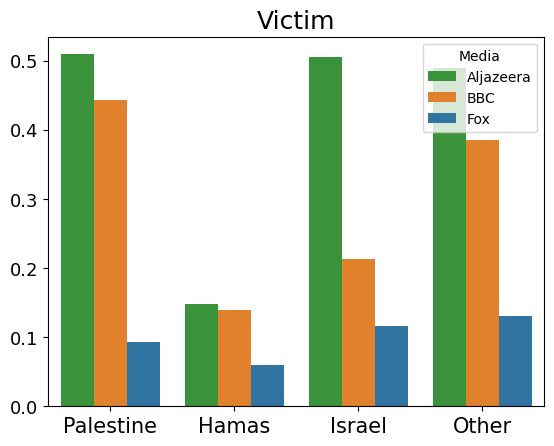

In [605]:
plot('score_Palestine')

In [606]:
pub1, pub2, pub3 = 'alj', 'fox', 'bbc'

df1 = data[data.media == pub1]
df2 = data[data.media == pub2]
df3 = data[data.media == pub3]

i = 3
cols = ['score_Hamas', 'score_Israel', 'score_None', 'score_Palestine']

alj_df = df1.groupby(pd.Grouper(key='date', freq='D')).mean()[cols]
fox_df = df2.groupby(pd.Grouper(key='date', freq='D')).mean()[cols]
bbc_df = df3.groupby(pd.Grouper(key='date', freq='D')).mean()[cols]


y1 = alj_df.dropna(subset = [cols[i]])
y2 = fox_df.dropna(subset = [cols[i]])
y3 = bbc_df.dropna(subset = [cols[i]])

common_df = y1.merge(y2, how='inner', left_index=True, right_index=True, suffixes=("_alj", "_fox")).merge(y3, how='inner', left_index=True, right_index=True, suffixes=("_fox", "_bbc"))

In [607]:
y1.shape, y2.shape, y3.shape, common_df.shape

((460, 4), (403, 4), (433, 4), (373, 12))

In [622]:
i = 2

In [623]:
col = cols[i].split('_')[1]
col

'None'

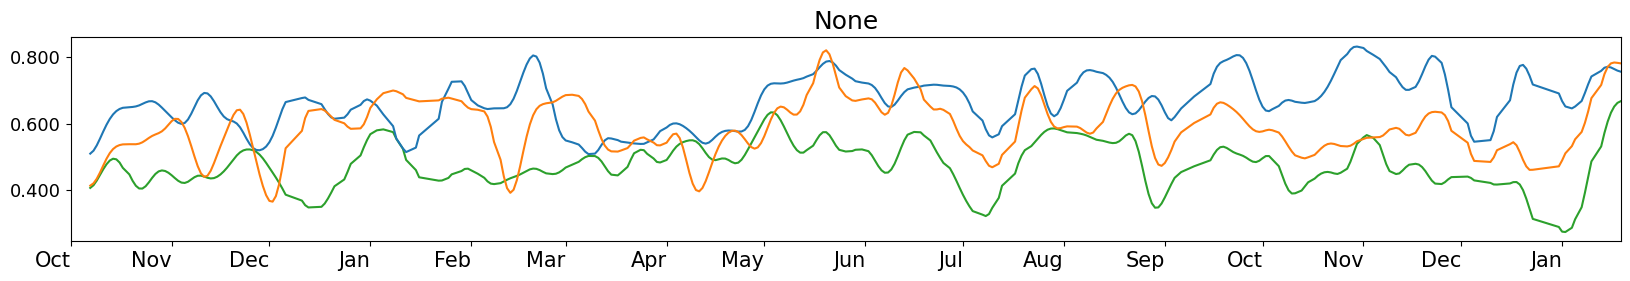

In [624]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

i = 0
smoothed_y1 = gaussian_filter1d(common_df[f'score_{col}_alj'], sigma=3)
smoothed_y2 = gaussian_filter1d(common_df[f'score_{col}_fox'], sigma=3)
smoothed_y3 = gaussian_filter1d(common_df[f'score_{col}'], sigma=3)

df = pd.DataFrame([smoothed_y1, smoothed_y2, smoothed_y3]).T
df.index = common_df.index
df

df[0].plot(color = '#2ca02c')
df[1].plot(color = '#1f77b4')
df[2].plot(color = '#ff7f0e')

plt.gcf().set_size_inches(20, 3) 

# Set equidistant months on x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xlim(pd.Timestamp('2023-10-01'), common_df.index[-1])  
plt.gca().set_xlabel('')
# plt.gca().tick_params(axis='y', pad=10)
# plt.gca().tick_params(axis='x', direction='out', length=16) 
# plt.gca().tick_params(axis='x', labelpad=10)
plt.title(col, fontsize=18)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))

plt.legend(title="Media", title_fontsize=14, labels = ['Aljazeera', 'Fox', 'BBC'], fontsize = 12)
plt.legend().set_visible(False)
plt.xticks(rotation = 0, fontsize = 15)
# plt.yticks(rotation = 0, fontsize = 15)
plt.savefig(f"results/fig/Victim_{col}.png", dpi=300, bbox_inches='tight', transparent=True)  # Save as PNG

plt.show()

In [457]:
data.columns

Index(['Unnamed: 0', 'id', 'indexed_date', 'language', 'media_name',
       'media_url', 'publish_date', 'headline', 'url', 'labels',
       'entity_labels', 'lab', 'entities', 'lang', 'pal_ent', 'hamas_ent',
       'isr_ent', 'other_ent', 'date', 'Lab_4c', 'Label_4c', 'score_BC',
       'score_None', 'score_WC', 'media'],
      dtype='object')

In [494]:
def get_dataframe(attr):

    temp_df = pd.DataFrame()

    temp_df['entity'] = ['Palestine'] * 3 + ['Hamas'] * 3 + ['Israel'] * 3 + ['Other'] * 3
    temp_df['media'] = ['Aljazeera', 'BBC', 'Fox'] * 4

    scores = pal_entity_mentioned_df.groupby('media').mean()[f'{attr}'].tolist() + \
    hamas_entity_mentioned_df.groupby('media').mean()[f'{attr}'].tolist() + israel_entity_mentioned_df.groupby('media').mean()[f'{attr}'].tolist() + \
    other_entity_mentioned_df.groupby('media').mean()[f'{attr}'].tolist()

    temp_df[attr] = scores
    
    return temp_df

In [504]:
df1 = get_dataframe('score_ES')
df2 = get_dataframe('score_PS')

df = df1.merge(df2, on = ['entity', 'media'])
# df = df[df.]
df['score_ES'] = df['score_ES'] * -1

ent = 'Israel'
df = df[df['entity'] == ent]
df.reset_index(inplace=True)
df

,index,entity,media,score_ES,score_PS
0,6,Israel,Aljazeera,-0.160318,0.106566
1,7,Israel,BBC,-0.338754,0.112401
2,8,Israel,Fox,-0.429646,0.159108


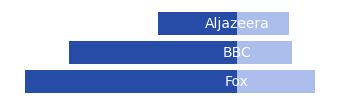

In [505]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# df1 = get_dataframe('score_O')
# df2 = get_dataframe('score_S')

# df = df1.merge(df2, on = ['entity', 'media'])
# # df = df[df.]
# df['score_VE'] = df['score_VE'] * -1

# ent = 'Palestine'
# df = df[df['entity'] == ent]
# df.reset_index(inplace=True)
# df

# Melt the dataframe for seaborn
df_melted = df.melt(id_vars=['entity', 'media'], value_vars=['score_ES', 'score_PS'],
                    var_name='score_type', value_name='score')

# Create a catplot to control spacing
g = sns.catplot(x='score', y='media', hue='score_type', data=df_melted, 
                kind='bar', height=2, aspect=2, dodge=False, capsize=0, errwidth=0, legend=False, palette=['#1044BC', '#A1BBF7'])

# hamas = ['#52A22A', '#B6E69E']
# Israel = ['#1044BC', '#A1BBF7']
# Palestine = ['#D1103A', '#F68DA4']
# Other = ['#DA7407', '#FBC488']

# Adjust the bar width and spacing
# g.set_axis_labels('', 'Entity')

g.fig.subplots_adjust(left=0.1, right=0.9)  # Adjust left/right spacing to bring bars closer

# g.ax.set_title('Divergent Bar Plot')
# g.ax.title.set_position([0.38, 1.05])

for i in range(len(df)):
    g.ax.text(0, i, df['media'][i], color='white', ha='center', va='center')

g.ax.set_xlabel('')
g.ax.set_ylabel('')
    
g.ax.set_yticks([])
g.ax.set_xticks([])

# Add positive and negative scores to the bars
# for i, (pos, neg) in enumerate(zip(df['score_O'], df['score_S'])):
#     g.ax.text(pos * 1/2, i, str(round(pos,3)), color='white', ha='left', va='center')
#     g.ax.text(neg  * 1/2, i, str(round(-1 * neg,3)), color='white', ha='right', va='center')
    
sns.despine()
for spine in g.ax.spines.values():
    spine.set_visible(False)

plt.savefig(f"results/fig/{ent}.png", dpi=300, bbox_inches='tight', transparent=True)  # Save as PNG
plt.show()

In [ ]:
data.columns

In [ ]:
def plot(df):
    sns.set_context(rc={'xtick.labelsize': 40, 'ytick.labelsize': 13})
    ax = sns.barplot(df, x="entity", y= 'score', hue="media")
    ax.set_title(label.title(), fontsize=18)
    ax.tick_params(axis='x', labelsize=15)
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.legend().set_visible(False)
  
    # plt.savefig(f"results/fig/{attr}.png", dpi=300, bbox_inches='tight', transparent=True)  # Save as PNG

def get_df(data, entity):
    df = data[['media', f'score_{entity}']].rename(columns = {f'score_{entity}' : 'score'})
    df['entity'] = [entity] * df.shape[0]
    return df

df1 = get_df(data, 'Hamas')
df2 = get_df(data, 'Israel')
df3 = get_df(data, 'Palestine')
df4 = get_df(data, 'None')

# df1 = get_df(hamas_entity_mentioned_df, 'Hamas')
# df2 = get_df(israel_entity_mentioned_df, 'Israel')
# df3 = get_df(pal_entity_mentioned_df, 'Palestine')
# df4 = get_df(other_entity_mentioned_df, 'None')

df_ = pd.concat((df2, df1, df3, df4), axis = 0)

plot(df_)

In [ ]:
pal_entity_mentioned_df['entity_group'] = ['Pal'] * pal_entity_mentioned_df.shape[0]
hamas_entity_mentioned_df['entity_group'] = ['Hamas'] * hamas_entity_mentioned_df.shape[0]
israel_entity_mentioned_df['entity_group'] = ['Israel'] * israel_entity_mentioned_df.shape[0]
other_entity_mentioned_df['entity_group'] = ['Other'] * other_entity_mentioned_df.shape[0]

df = pd.concat((pal_entity_mentioned_df, hamas_entity_mentioned_df, israel_entity_mentioned_df, other_entity_mentioned_df), axis = 0)

In [ ]:
df.shape, df.columns

In [ ]:
def normalize(dist):

    return (dist - dist.min()) / (dist.max() - dist.min())

df[f'{cols[0]}_norm'] = normalize(df[cols[0]])
df[f'{cols[1]}_norm'] = normalize(df[cols[1]])

In [ ]:
df[f'{cols[0]}_norm'].describe()

In [ ]:
import seaborn as sns  
import matplotlib.pyplot as plt  

sns.scatterplot(data=df, x=f'{cols[0]}_norm', y=f'{cols[1]}_norm', hue='entity_group')  
plt.show()

In [ ]:
# import matplotlib.pyplot as plt  

plt.hist([df[cols[0]], df[cols[1]]], bins=20, stacked=True, label=[cols[0], cols[1]])  
plt.xlabel('Probability')  
plt.ylabel('Count')  
plt.legend()  
plt.show()

In [ ]:
df_ = df[df['media'] != 'bbc']

sns.set_context(rc={'xtick.labelsize': 40, 'ytick.labelsize': 40})
ax = sns.violinplot(data=df_, x = cols[0], y = 'entity_group', hue = 'media', split=True)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.legend(fontsize=15)
# ax.set_title(attr.upper(), fontsize = 25)

In [ ]:
sns.displot(pal_entity_mentioned_df, x=cols[1], hue="media", kind="kde", fill=True)

In [ ]:
sns.displot(israel_entity_mentioned_df, x=cols[1], hue="media", kind="kde", fill=True)

In [ ]:
sns.swarmplot(data=df, x='entity_group', y=cols[1], hue='media')  